In [1]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import albumentations as alb

In [2]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
images=tf.data.Dataset.list_files('data/images/*jpg',shuffle=False)

In [5]:
images.as_numpy_iterator().next()

b'data\\images\\8baf50e9-99b2-11ee-ba8e-aa8a27fd4345.jpg'

In [6]:
def load_img(x):
  byte_img=tf.io.read_file(x)
  img=tf.io.decode_jpeg(byte_img)
  return img

In [7]:
images=images.map(load_img)

In [8]:
images.as_numpy_iterator().next()

array([[[161, 142, 138],
        [148, 129, 123],
        [146, 124, 113],
        ...,
        [234, 224, 248],
        [233, 225, 249],
        [231, 226, 249]],

       [[161, 140, 139],
        [156, 135, 130],
        [148, 125, 117],
        ...,
        [239, 227, 249],
        [236, 227, 248],
        [235, 227, 248]],

       [[165, 140, 143],
        [151, 127, 125],
        [145, 122, 114],
        ...,
        [243, 229, 246],
        [242, 228, 245],
        [243, 230, 247]],

       ...,

       [[128, 132, 133],
        [120, 124, 125],
        [126, 127, 129],
        ...,
        [145, 180, 248],
        [147, 180, 251],
        [152, 182, 255]],

       [[111, 125, 125],
        [113, 125, 125],
        [123, 131, 133],
        ...,
        [143, 179, 253],
        [143, 179, 255],
        [143, 179, 255]],

       [[110, 128, 128],
        [108, 124, 124],
        [117, 128, 130],
        ...,
        [141, 179, 254],
        [144, 181, 255],
        [143, 180, 255]]

In [9]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [37]:
image_generator = images.batch(4).as_numpy_iterator()

In [38]:
plot_images = image_generator.next()

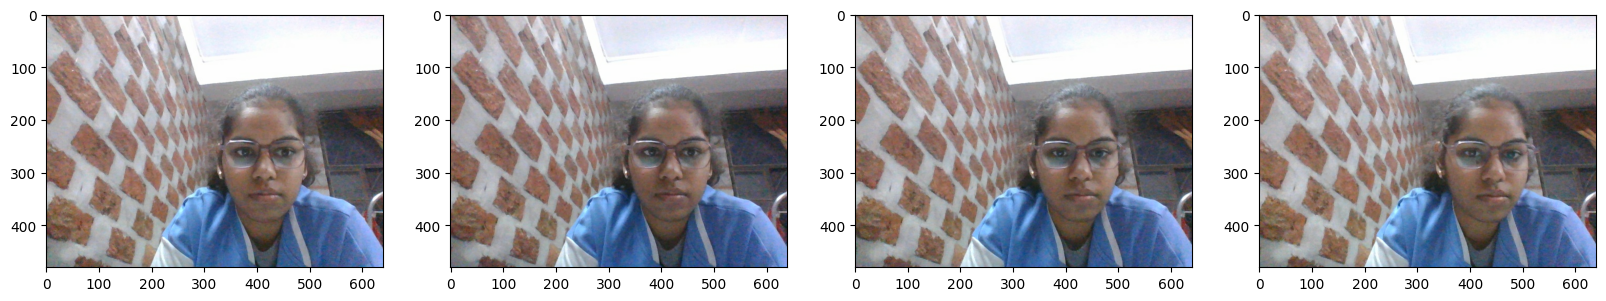

In [39]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [41]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [46]:
90*.7

62.99999999999999

In [47]:
90*.15

13.5

In [48]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

In [49]:
img = cv2.imread(os.path.join('data','train', 'images','8d60dd65-99b2-11ee-bd07-aa8a27fd4345.jpg'))

In [53]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                

        except Exception as e:
            print(e)

In [56]:
train_images = tf.data.Dataset.list_files('data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_img)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [57]:
test_images = tf.data.Dataset.list_files('data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_img)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [58]:
val_images = tf.data.Dataset.list_files('data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_img)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [59]:
train_images.as_numpy_iterator().next()

array([[[0.5745098 , 0.48464054, 0.44934642],
        [0.59313726, 0.48235294, 0.39411765],
        [0.65392154, 0.5173202 , 0.5408496 ],
        ...,
        [0.92483723, 0.8709153 , 0.92875856],
        [0.93235296, 0.8862745 , 0.9284314 ],
        [0.9457515 , 0.89444435, 0.96960807]],

       [[0.7575164 , 0.6751634 , 0.64738566],
        [0.5529412 , 0.43137255, 0.38627452],
        [0.63790846, 0.5356209 , 0.5287582 ],
        ...,
        [0.9633985 , 0.89869267, 0.95620906],
        [0.92058825, 0.91568625, 0.9676471 ],
        [0.93921566, 0.9042483 , 0.95588213]],

       [[0.7372549 , 0.72222227, 0.7310458 ],
        [0.5901961 , 0.54313725, 0.5137255 ],
        [0.5591503 , 0.44607842, 0.40457514],
        ...,
        [0.93692833, 0.89085   , 0.9578435 ],
        [0.9       , 0.91568625, 0.9705882 ],
        [0.9464054 , 0.9071897 , 0.9418299 ]],

       ...,

       [[0.44705883, 0.4882353 , 0.44640523],
        [0.4598039 , 0.5117647 , 0.49607843],
        [0.4781046 , 0

In [60]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [91]:
train_image_folder = 'data/train/images'


In [92]:
train_image_files = [f for f in os.listdir(image_folder) if f.lower().endswith('.jpg')]

In [93]:
train_image_data = []

In [94]:
for train_img_file in train_image_files:
    train_img_path = os.path.join(train_image_folder, train_img_file)
    train_image_info = {'file_path': train_img_path,'metadata': { 'description': 'Some description', 'author': 'Author name',}}
    train_image_data.append(image_info)

In [95]:
train_data = {'images': image_data}

In [96]:
train_json_filename = 'data/train/labels.json'
with open(json_filename, 'w') as json_file:
    json.dump(data, json_file, indent=4)

print(f"Image data saved to {json_filename}")

Image data saved to data/train/labels.json


In [98]:
test_image_folder = 'data/test/images'
test_image_files = [f for f in os.listdir(image_folder) if f.lower().endswith('.jpg')]
test_image_data = []
for test_img_file in test_image_files:
    test_img_path = os.path.join(test_image_folder, test_img_file)
    test_image_info = {'file_path': img_path,'metadata': { 'description': 'Some description', 'author': 'Author name',}}
    test_image_data.append(image_info)
test_data = {'images': image_data}
test_json_filename = 'data/test/labels.json'
with open(test_json_filename, 'w') as json_file:
    json.dump(data, json_file, indent=4)

print(f"Image data saved to {test_json_filename}")

Image data saved to data/test/labels.json


In [101]:
val_image_folder = 'data/val/images'
val_image_files = [f for f in os.listdir(image_folder) if f.lower().endswith('.jpg')]
val_image_data = []
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    image_info = {'file_path': img_path,'metadata': { 'description': 'Some description', 'author': 'Author name',}}
    image_data.append(image_info)
val_data = {'images': image_data}
val_json_filename = 'data/val/labels.json'
with open(val_json_filename, 'w') as json_file:
    json.dump(data, json_file, indent=4)

print(f"Image data saved to {val_json_filename}")

Image data saved to data/val/labels.json


In [77]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalAvgPool2D,GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [78]:
vgg=VGG16(include_top=False)



58889256/58889256 [==============================] - 9s 0us/step


In [79]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [80]:
def build_model():
  input_layer=Input(shape=(120,120,3))
  vgg=VGG16(include_top=False)(input_layer)
  f1=GlobalMaxPooling2D()(vgg)
  class1=Dense(2048,activation="relu")(f1)
  class2=Dense(1,activation="sigmoid")(class1)
  f2=GlobalMaxPooling2D()(vgg)
  reg1=Dense(2048,activation="relu")(f2)
  reg2=Dense(4,activation="sigmoid")(class2)
  facetracker=Model(inputs=[input_layer],outputs=[class2,reg2])
  return facetracker

In [81]:
facetracker=build_model()

In [82]:
facetracker.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 2048)              1050624   
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
 dense_3 (Dense)             (None, 4)                 8         
                                                             

In [85]:
train_labels = tf.data.Dataset.list_files('data\\train\\labels.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [102]:
test_labels = tf.data.Dataset.list_files('data/test/labels.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [104]:
val_labels = tf.data.Dataset.list_files('data\\val\\labels.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [105]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(30, 1, 30, 1, 30, 1)

In [106]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [107]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [108]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [111]:
data_samples = train.as_numpy_iterator()

In [117]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [119]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000, 
    decay_rate=0.9,
    staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [120]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [121]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss